# PCA Statistical Arbitrage

(This notebook can be found on GitHub: https://github.com/rodler/quantinsti_statarb)

### Dr Tom Starke 

*Homepage: www.aaaquants.com *

*Email: tom@aaaquants.com *

*Linkedin: Dr Tom Starke *

### What we will learn:
- Building a PCA manually
- Conduct a pairs-trading backtest using PCA
- Simulation of multiple cointegrated assets
- Sector statistical arbitrage using PCA 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as stats
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
import scipy
import statsmodels.api as sm
import pandas as pd
from statsmodels.tsa.stattools import coint
import matplotlib
from itertools import groupby, count
import pickle
%matplotlib inline

### Short recap: cointegration versus correlation

- Cointegrated price series do not necessarily have to be correlated and vice-versa 

- Drunk and her dog: https://www.researchgate.net/publication/254330798_A_Drunk_and_Her_Dog_An_Illustration_of_Cointegration_and_Error_Correction

- Same behaviour in the markets and causality relationships change. For more information please refer to Engle-Granger causality (https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=1&cad=rja&uact=8&ved=2ahUKEwjcvKPcsqDeAhXTbCsKHTmNAe8QFjAAegQIBxAB&url=https%3A%2F%2Fen.wikipedia.org%2Fwiki%2FGranger_causality&usg=AOvVaw1mYq3HhcjsVNJ9zJ6zgqdV)


Engel-Granger Causality

### Principal Component Analysis (PCA) to find structure in complex systems
https://systematicedge.wordpress.com/2013/06/02/principal-component-analysis-in-portfolio-management/

- Unsupervised machine learning.
- "Principal components" are "modes" of a system, similar to vibrational overtones of a guitar string.
- They are eigenvectors of the covariance matrix.
- Number of eigenvectors equals the number of features.
- "Dimensionality reduction": reducing the number of eigenvectors.
- Eigenvectors are "orthogonal" - uncorrelated.

To illustrate this, let's produce two correlated time series:

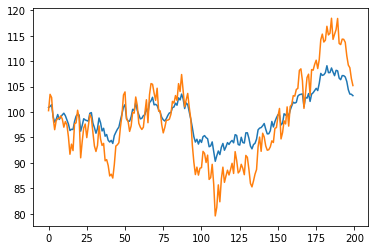

In [2]:
# Create a random seed for consistency
np.random.seed(20)

# Produce a series as the cumulative sum of normally distributed random numbers.
x = np.cumsum(np.random.randn(200)) + 100

# Produce a second series with the same behaviour but higher standard deviation.
y = x*2 + np.random.randn(200) - 100

# Generate an array to be used in our PCA calculation.
# Note that we have to de-mean our values first.
R = np.array([x-np.mean(x),y-np.mean(y)])

# Plot x and y
plt.plot(x)
plt.plot(y)

For PCA we calculate the covariance matrix of R and subsequently the eigenvectors and eigenvalues. Here, the eigenvectors tell us the axis of the largest variance and the eigenvalues tell us the magnitude of the variance along each axis.

In [3]:
# Calculate the covariance matrix
S = np.cov(R)
print('Cov Matrix:', S)

# Calculate the eigenvalues and eigenvectors
EIG = np.linalg.eig(S)
print('Eigenvalues: ',EIG[0])
print('Eigenvectors: ',EIG[1])

Cov Matrix: [[17.01547369 33.69556579]
 [33.69556579 67.62804956]]
Eigenvalues:  [ 0.18152713 84.46199612]
Eigenvectors:  [[-0.89457408 -0.4469197 ]
 [ 0.4469197  -0.89457408]]


Now we create the vectors in space and plot our x and y values. We can see that we are capturing the direction of the largest variance. These vectors are called "principal components".

In [4]:
# Extract the eigenvectors from EIG
EV = EIG[1]

# Create x-values for plotting eigenvectors
xx = np.linspace(min(R[0,:]),max(R[0,:]),200)

# Create y-values for plotting eigenvectors

yy1 = (EV[1][0]/EV[0][0])*xx
yy2 = (EV[1][1]/EV[0][1])*xx

The most significant eigenvector is the one with the highest eigenvalue. Here we extract its row number.

In [5]:
most_significant_factor = np.argmax(EIG[0])
print('Most significant factor: ',most_significant_factor)

Most significant factor:  1


Now we plot our de-meaned price values along with their priciple components.

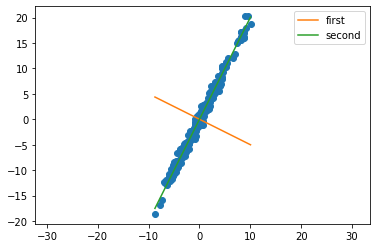

In [6]:
# Plot de-meaned x - y correlation
plt.plot(R[0,:],R[1,:],'o')

# Plot the first principal component
plt.plot(xx,yy1,label='first')

# Plot the second principal component
plt.plot(xx,yy2,label='second')

plt.legend()

# Make sure axis are equal to illustrate orthogonality
plt.axis('equal');

We can see that for the two-dimensional case we get exactly two principal components. With the priciple components we can now calculate our abstract factors:

In [7]:
# Calculating the factor values from the eigenvector
factors = np.dot(EV.T,R)

The plot below shows how well our factors are correlated with x and y. Note that for each return curve we have two factors.
We can see that component 1 with an eigenvalue of 84.46 has a strong correlation with x and y, component 0 with an eigenvalue of only 0.18 does not.

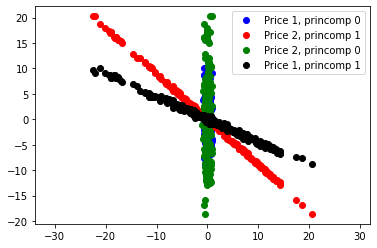

In [8]:
# Correlations between factors
plt.plot(factors[0],R[0,:],'bo',label='Price 1, princomp 0')
plt.plot(factors[1],R[1,:],'ro',label='Price 2, princomp 1')
plt.plot(factors[0],R[1,:],'go',label='Price 2, princomp 0')
plt.plot(factors[1],R[0,:],'ko',label='Price 1, princomp 1')
plt.axis('equal')
plt.legend();

### PCA Pairs Trade

- The use of PCA for pairs trading and subsequent generalisation of the technique to large portfolios.
- Produce pair of cointegrated price series.
- Build a backtest.
- Analyse the results.

First we create an algorithm for "drunk and dog" cointegration. Here,
- T are the starting values
- Sigma are the standard deviations of each path.
- c is a variable that determines how strongly both returns are connected.
- if c[0] = 0 and c[1] = 0 -> both are random walks (drunk does not own dog).
- if one c is zero and the other non-zero there is a one way causality (drunk owns dog).
- if both c are non-zero there is two-way causality (dog sometimes pulls drunk).

In [9]:
def make_coint_0(N,T0=[0,0],sigma=[1,1],c=[0.1,0.1]):
    '''
    Algorithm from:
    https://www.researchgate.net/publication/254330798_A_Drunk_and_Her_Dog_An_Illustration_of_Cointegration_and_Error_Correction
    '''
    X = [0]
    Y = [0]
    for i in range(N):
        rx = np.random.randn()*sigma[0] - c[0]*(X[-1] - Y[-1])
        ry = np.random.randn()*sigma[1] + c[1]*(X[-1] - Y[-1])
        X.append(X[-1]+rx)
        Y.append(Y[-1]+ry)
    return np.array(X)+T0[0],np.array(Y)+T0[1]

When plotting X and Y we can see that they follow each other closely.
Now, vary c as follows and observe what happens:
- c = [ 0.9, 0.0 ]
- c = [ 0.1, 0.1 ]
- c = [ 0.1, 0.9 ]
- c = [ 0.0 , 0.0]

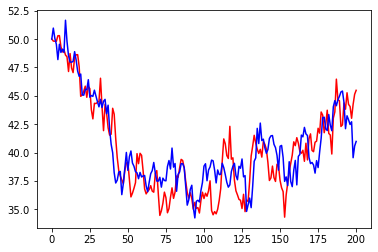

In [10]:
np.random.seed(452)
X,Y = make_coint_0(200,T0=[50,50],c=[0.1,0.1])
plt.plot(X,'r-',Y,'b-');

Assessing the quality of our cointegration:
- Critical values for 0.1, 0.05 and 0.01.
- T-statistic should be below crit.

In [11]:
crit = coint(X,Y)
print('Critical Values:',crit[2])
print('T-statistic:',crit[0])
print('P-value:',crit[1])

Critical Values: [-3.95203768 -3.36685108 -3.065724  ]
T-statistic: -5.574176718429718
P-value: 1.2687688654668503e-05


### Application of PCA to pairs trading:
- Use the sklearn PCA package to generate components.
- Linear regression with the price data.
- Z-score the residual to normalise for varying price levels and volatility.
- Trade when residual sufficiently deviates from mean. 
- Use of log prices can help to mitigate large price swings (e.g. in penny stocks)

Below the code for the PCA pairs trade:

In [12]:
def Zscore(X):
    return np.array((X - np.mean(X)) / np.std(X))

def run_pca(pr,components=1,log_prices=True):
    
    # Instanciate PCA 
    pca = PCA(n_components=components)
    px = pr.T-np.mean(pr.T)
    
    if log_prices:
        
        # Calculate the priciple components using log prices
        comps = pca.fit(np.log(pr.T)).components_.T
        
        # Create the factors from the pricinple components
        factors = sm.add_constant(pr.T.dot(comps))
        
    else:
        
        # Calculate the N priciple components using normal prices
        comps = pca.fit(px).components_.T
        
         # Create the factors from the pricinple components
        factors = sm.add_constant(px.dot(comps))  
        

    
    # Regress each factor with the actual underlying prices
    mm = [sm.OLS(s.T, factors).fit() for s in pr]
    
    # Calculate the residuals
    resids = list(map(lambda x: x.resid, mm))
    
    return resids, factors

- Running the PCA we can now see the factors with equal values of opposite sign.
- Same as in "regular" pairs trade where opposite sign is expressed by long/short.
- PCA gives reversible results when X and Y are switched, linear regression does not.

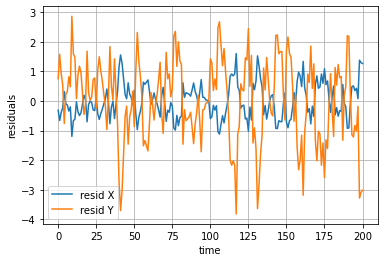

In [13]:
# Create input array from cointegrated price series
R = np.array([X,Y,X])

# Run the PCA calculation
residuals, factors = run_pca(R,log_prices=True)

# Plot the residuals
plt.plot(residuals[0],label='resid X')
plt.plot(residuals[1],label='resid Y')
plt.xlabel('time')
plt.ylabel('residuals')
plt.legend()
plt.grid()

As a side-node, observe that linear regression is not reversible.
- Residuals are calculated as distances to fitting line along to y-axis.
- In PCA residuals are calculated orthogonal to principal component.

In [14]:
m = np.polyfit(X,Y,1)[0]
m_rev = np.polyfit(Y,X,1)[0]
print('Slope of regression:',m)
print('Inverse slope of reverse regression:',1/m_rev)

Slope of regression: 0.7978929779688259
Inverse slope of reverse regression: 1.0528140853084136


### Pairs-Trade Backtest
- Sequentially step through time and instruments.
- Calculate if z-score of residuals is large enough to trade.
- If in trade, see if residuals have mean reverted enough to exit.
- Calculate the pnl.

(For simplicity we calculate the residuals first, thus introducing a forward-looking bias. This is to make the calcs faster and it is rectified later.)

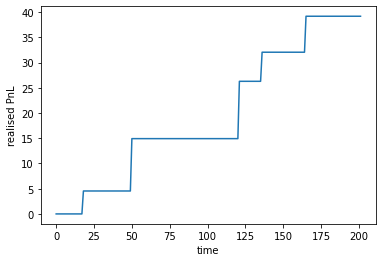

In [15]:
inpos = np.zeros(R.shape[0]) # side: long=+1; short=-1
pnl = [0] # PnL vector
bw = 2 # z-score threshold (bandwidth)
op = {} # dict of entry prices

# loop through time steps
for i in range(len(residuals[0])):
    p = 0 # initialise pnl-calc for a particular time step
    
    # loop through instruments
    for inst in range(R.shape[0]):
        
        # calculate the z-score of residuals
        zs = Zscore(residuals[inst])[i]
        
        # Entry condition: z-score above bandwith and no position on
        if np.abs(zs)>bw and inpos[inst] == 0:
            op[inst] = R[inst,i] # record the open price
            inpos[inst] = zs  # tell algo that we have a position
            
        # Exit condition: z-score has crossed zero and position on
        elif zs*np.sign(inpos[inst])<0:
            
            # Calculate pnl as (exit-entry)*side
            p+=((-R[inst,i]+op[inst])*np.sign(inpos[inst]))
            inpos[inst] = 0 # set side to zero
    
    # append the new pnl to vector
    pnl.append(p)
    
# Plot the results of the backtest
plt.plot(np.cumsum(pnl),'-')
plt.xlabel('time')
plt.ylabel('realised PnL')
plt.show()

### Simulate sector cointegration

- Simulated time series provide understandable results. 
- Stocks within a sector are often cointegrated.
- Maths of "Drunk and her dog" generalisation shown below:

\begin{align}
c_{ij} = \Bigg\{ 
\begin{split}
-a_{ij} \quad for \quad i \leq j \\ 
a_{ij} \quad for \quad i \geq j \\ 
-a_{ij} \quad for \quad i = j
\end{split}
\end{align}

\begin{align}
X_{t}^{(i)}-X_{t-1}^{(i)} = \sum_{j} c_{ij} X_{t-1}^{(j)} + \epsilon_{i} \quad with \quad a_{ij} \geq 0
\end{align}

- *X* denotes the time series, *c* is the causality matrix.
- *a* are the positive elements of the causality matrix. 

(Note that the *a's* denote the relationships between different series. We can simply use random numbers to start with. As we increase the number of series, we need to keep *a* small to avoid positive feedback scenarios.) 

Below the code that implements the above equations.

In [16]:
def make_coint_1(N,steps,a=0.1):
    X = [np.zeros(N)]
    
    # Create the causality matrix
    c = (np.tril(np.ones(N))-np.triu(np.ones(N))-np.diag(np.ones(N),0))*a #c = np.random.rand(N,N)*0.1

    # loop through time steps
    for i in range(steps):
        
        # Calculate the returns for each time series
        rx = (np.sum(c*X[-1],axis=1)+np.random.randn(N))
        
        # Add the new return to the last price of the time series
        X.append(X[-1]+rx)
        
    # return array of all series
    return np.array(X).T

Let's create a cointegrated pair with this technique.

__Play with this by varying *a* and observe the results.__

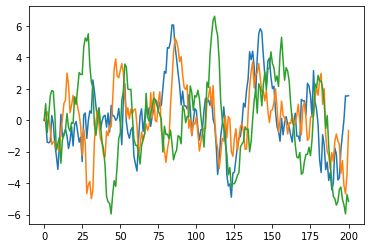

In [17]:
np.random.seed(21)
N = 3
a1 = 0.1 # general case
a2=[[0.02,0.1],[0.1,0.02]] # for N = 2
a3=[[0.06,0.04,0.08],[0.06,0.06,0.04],[0.06,0.08,0.04]] # for N = 3
X1 = make_coint_1(N,200,a=a1).T

for i in range(N):
    plt.plot(X1[:,i])

We can see we have produced a set of stationary time series, testing for cointegration we see that most of them are below the critical values.

In [18]:
print('Critical values:',coint(X1.T[0],X1.T[1])[2])
for i in range(X1.T.shape[0]):
    for k in range(i,X1.T.shape[0]):
        if not i==k:
            print('t-stats for coint of series %s and %s:'%(i,k), coint(X1.T[i],X1.T[k])[0])
        

Critical values: [-3.95203768 -3.36685108 -3.065724  ]
t-stats for coint of series 0 and 1: -4.4134504273519495
t-stats for coint of series 0 and 2: -3.750039650509555
t-stats for coint of series 1 and 2: -4.537611349936926


Let's now apply our statistical arbitrage system to a simple long/short pair in order to test if our system is working properly. First, let's produce a cointegrated time series and plot it to confirm its properties.

### PCA Portfolio Trading

- Application of strategy to larger portfolio.
- Careful with the causality coefficients as large numbers of strong cross-dependencies can create positive feedback loops between the series. 
- Larger N - higher to probability of the feedack loops for a given *alpha*.

__Please vary alpha in this exercise and observe how the behaviour of our time series changes.__

In [19]:
#np.random.seed(231)
N = 10
alpha = 0.06
X2 = make_coint_1(N,300,a=np.random.rand(N,N)*alpha) + 50

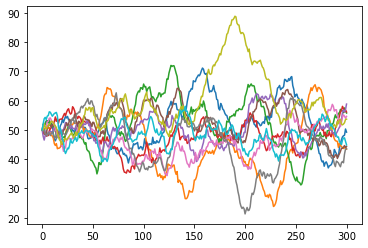

In [20]:
for i in X2:
    plt.plot(i)

### Cumulative explained variance

- 3 principle components explain 75% of variance
- Too many components lead to very high correlation and very small PnL/trade
- Enough PnL/trade to overcome trading costs

Text(0, 0.5, 'Explained Variance')

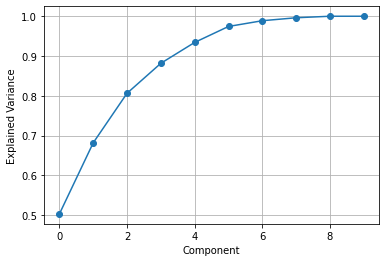

In [21]:
pca = PCA(n_components=10)
pca.fit(np.log(X2))

# Plot cumulative explained variance
plt.plot(np.cumsum(pca.explained_variance_)/np.sum(pca.explained_variance_),'-o')
plt.grid()
plt.xlabel('Component')
plt.ylabel('Explained Variance')

- Useful to look at the average t-statistics between all possible pairs.
- High average t-stats - good probability of strategy success.
- Johansen test tends to perform poorly out-of-sample.

In [22]:
# Cointegration test:
coints = []
print('Critical values:',coint(X2[0],X2[1])[2])
for i in range(X2.shape[0]):
    for k in range(i,X2.shape[0]):
        if not i==k:
            coints.append(coint(X2[i],X2[k])[0])
            
print('Average coint t-stats:',np.mean(coints))

Critical values: [-3.93331886 -3.35657281 -3.05861756]
Average coint t-stats: -2.691452457759271


- Simulated data can give us an understanding how well our backtest performs under idealised conditions. 

- In the next part we are looking at applying this algorithm to real market data using Quantopian.

### Sector-portfolio backtest

There are many strategies we can deploy based on our techniques such as:
- sort the z-scores of our factors and go long the lowest and short the N assets with the highest z-scores. 
- scale the position size of each instrument according to z-score.
- only rebalance portfolio when sum of z-scores exceeds a threshold.

All of them have their uses and they need to be tested on a case-by-case basis. Here, we choose the first example as shown below. This time we eliminate the forward-looking bias by recalculating the residuals at every time step.

In [23]:
mdata = pickle.load(open('marketdata.pick','rb'))

In [ ]:
pr = np.array(mdata).T#[:12,:]
max_pos=3
num_factors=3
initial_cash=1e6

entry = {} # create a vector of entry prices
pnls = [] # create a pnl vector

# Exit if we specified too large long/short position size
if max_pos > pr.shape[0]/2:
    print('max_pos too large!')
    adfadsf

# loop through the prices
for i,pri in enumerate(pr.T):

    # Make sure you have enough data points for PCA
    if i < 50: continue

    # Run the PCA, only on the past prices
    resids, factors = run_pca(pr.T[max([0,i-400]):i],num_factors,log_prices=False)
    zs = {}

    # Calculate the z-scores for each instrument. 
    for inst in range(len(pri)):
        try: zs[inst] = Zscore(resids[inst])[-1]
        except: pass

    pnl = 0
    # Calculate the Pnl for each position over the prevoius period
    for j,idx in enumerate(entry):

        # Calculate the position size
        # The sign of the position depends on the sign of the entry price
        pos = np.round((initial_cash/len(pri))/entry[idx])

        # Add up the pnls for all positions for the last period
        # We neutralize the sign of the entry price and let it 
        # come in through the position.
        pnl += (pri[idx]-np.abs(entry[idx]))*pos
    pnls.append(pnl)

    # Reset the portfolio
    entry = {}

    # Find the new instruments to be traded based on their z-scores
    idx_long = (np.argsort([zs[j] for j in zs])[:max_pos])
    idx_short = (np.argsort([zs[j] for j in zs])[-max_pos:])

    # Add them to the entry list
    # The entry gets a positive or negative sign depending on the side of the trade
    for idx in idx_long:
        entry[idx] = pri[idx]
    for idx in idx_short:
        entry[idx] = -pri[idx]

    print(i,sum(pnls))

50 0
51 -21.165999999994796
52 -106.57200000000252
53 -83.94700000000546
54 -26.833000000003423
55 -54.27699999999781
56 32.18999999999215
57 53.96399999998951
58 93.02200000001132
59 208.6330000000077
60 215.50800000000203
61 278.09200000000453
62 327.86000000000524
63 235.0630000000118
64 237.25000000000355
65 593.5150000000051
66 561.0220000000104
67 624.5780000000065
68 623.2400000000008
69 686.7020000000095
70 686.9269999999975
71 599.1580000000084
72 824.4550000000012
73 742.5780000000119
74 762.0660000000041
75 804.0080000000016
76 918.5370000000128
77 1008.8470000000062
78 1008.0530000000119
79 1119.1180000000052
80 1161.7720000000252
81 1261.7950000000046
82 1194.2060000000083
83 1377.6350000000086
84 1385.3770000000077
85 1328.324000000004
86 1304.390999999991
87 1324.1520000000141
88 1294.7050000000042
89 1301.8230000000015
90 1361.6370000000024
91 1376.067000000005
92 1275.9090000000215
93 1170.8990000000174
94 1127.4110000000112
95 1240.2160000000083
96 1215.7790000000175


415 995.9310000000316
416 1058.3100000000375
417 872.6590000000358
418 773.9200000000358
419 784.9370000000445
420 758.522000000046
421 804.4940000000411
422 893.5190000000446
423 751.1830000000382
424 895.0080000000439
425 883.6610000000462
426 783.4780000000732
427 812.5030000000708
428 910.6720000000726
429 858.547000000077
430 905.7370000000749
431 835.3680000000634
432 887.5140000000675
433 841.8280000000703
434 828.781000000074
435 919.0260000000682
436 996.1430000000623
437 1052.1480000000724
438 1035.9860000000622
439 981.1520000000597
440 1036.8400000000506
441 1046.3790000000602
442 995.7050000000709
443 943.3740000000685
444 936.4660000000603
445 886.6880000000813
446 921.1590000000758
447 758.104000000071
448 767.0030000000728
449 818.3180000000866
450 868.4570000000853
451 842.1330000000918
452 875.5410000000928
453 781.7360000000979
454 721.658000000101
455 715.81400000011
456 702.0390000001069
457 743.5060000001122
458 718.8580000001139
459 725.9060000001241
460 759.1420

788 -633.589999999732
789 -575.3309999997075
790 -770.3969999997156
791 -824.826999999717
792 -754.1219999997014
793 -868.1249999997151
794 -1045.9739999997066
795 -1083.0209999997192
796 -1053.1819999997067
797 -1073.0189999997153
798 -1186.3739999997208
799 -1233.4299999997145
800 -1159.2449999997175
801 -1204.1469999997012
802 -1062.4929999996925
803 -1262.6209999997072
804 -1045.408999999706
805 -886.1559999996955
806 -958.0069999997074
807 -908.3489999997225
808 -815.3629999997207
809 -944.4379999997327
810 -861.2889999997232
811 -1010.9069999997283
812 -1041.4599999997363
813 -1024.8669999997178
814 -1098.8489999997284
815 -1101.849999999724
816 -1196.9309999997351
817 -1169.3039999997284
818 -1111.2919999997314
819 -1173.3899999997252
820 -1164.23299999972
821 -1171.4459999997193
822 -1098.5209999997192
823 -1041.7269999997268
824 -1124.3009999997412
825 -1049.299999999741
826 -999.9949999997373
827 -908.8639999997413
828 -817.5959999997499
829 -754.3789999997435
830 -672.271999

1131 -1388.2299999998006
1132 -1437.1219999998227
1133 -1516.4079999998185
1134 -1487.9729999998333
1135 -1516.6499999998332
1136 -1550.6229999998257
1137 -1517.777999999831
1138 -1511.456999999843
1139 -1483.6049999998586
1140 -1406.08899999986
1141 -1367.499999999869
1142 -1388.2309999998513
1143 -1404.941999999847
1144 -1317.8519999998566
1145 -1288.0359999998689
1146 -1237.4639999998717
1147 -1215.587999999873
1148 -1273.78899999985
1149 -1221.612999999864
1150 -1229.0919999998612
1151 -1188.7729999998564
1152 -1146.3349999998468
1153 -1168.6439999998481
1154 -1151.8349999998466
1155 -1231.2559999998443
1156 -1249.1339999998588
1157 -1215.2549999998453
1158 -1261.1179999998521
1159 -1150.82599999985
1160 -1148.8739999998495
1161 -1108.5499999998472
1162 -1078.4009999998534
1163 -1095.6059999998463
1164 -1065.8489999998526
1165 -1236.9019999998395
1166 -1358.366999999841
1167 -1303.3719999998323
1168 -1245.0139999998366
1169 -1116.67799999983
1170 3387.39600000017
1171 3638.65800000

1485 4799.638000000146
1486 4751.308000000144
1487 4719.811000000138
1488 4779.433000000142
1489 4750.435000000136
1490 4705.609000000137
1491 4754.702000000132
1492 4682.002000000126
1493 4677.472000000117
1494 4695.742000000116
1495 4769.995000000118
1496 4804.6590000001215
1497 4781.622000000117
1498 4778.813000000134
1499 4818.635000000122
1500 4809.776000000127
1501 4801.809000000139
1502 4787.8140000001285
1503 4774.972000000121
1504 4789.152000000133
1505 4881.1470000001145
1506 4903.818000000114
1507 4881.76300000012
1508 4870.187000000131
1509 4905.624000000136
1510 4877.1710000001385
1511 4817.7600000001385
1512 4776.6440000001385
1513 4756.350000000141
1514 4715.334000000138
1515 4680.869000000122
1516 4681.135000000135
1517 4687.7550000001065
1518 4704.014000000109
1519 4716.143000000102
1520 4722.497000000109
1521 4694.6970000001165
1522 4725.1570000001175
1523 4758.873000000123
1524 4771.15900000012
1525 4675.774000000118
1526 4684.0990000001175
1527 4701.00800000012
1528

1844 4816.3929999999855
1845 4839.688999999977
1846 4864.205999999967
1847 4851.30399999999
1848 4871.037999999998
1849 4929.996999999985
1850 5021.842000000009
1851 5069.538999999998
1852 5044.935000000006
1853 5057.761000000008
1854 5080.065
1855 5068.74
1856 5007.898000000003
1857 5026.677999999993
1858 4974.746999999996
1859 4971.655999999988
1860 4958.280999999994
1861 4927.397999999991
1862 4877.453999999995
1863 4854.800999999978
1864 4819.301999999978
1865 4764.860999999977
1866 4886.645999999992
1867 4904.124999999982
1868 4885.3549999999805
1869 4866.111999999971
1870 4868.8789999999735
1871 4867.562999999971
1872 4831.72299999997
1873 4865.712999999973
1874 4831.580999999977
1875 4872.525999999972
1876 4821.468999999963
1877 4791.020999999969
1878 4814.647999999966
1879 4838.861999999961
1880 4807.9979999999505
1881 4835.828999999975
1882 4810.172999999967
1883 4859.715999999974
1884 4833.212999999981
1885 4806.058999999979
1886 4830.817999999977
1887 4824.448999999969
1888 

2200 2762.4029999998584
2201 2777.2719999998567
2202 2771.714999999843
2203 2784.4629999998524
2204 2736.8219999998473
2205 2769.164999999851
2206 2818.2829999998476
2207 2811.8919999998434
2208 2811.4199999998577
2209 2872.5189999998456
2210 2863.354999999825
2211 2842.9749999998344
2212 2849.7069999998307
2213 2888.1469999998435
2214 2896.6469999998394
2215 2919.382999999845
2216 2807.3339999998348
2217 2791.9529999998304
2218 2806.194999999829
2219 2795.582999999831
2220 2806.591999999832
2221 2799.395999999837
2222 2850.254999999838
2223 2965.472999999828
2224 2886.8529999998236
2225 2729.580999999824
2226 2835.5289999998267
2227 2764.142999999826
2228 2709.863999999834
2229 2708.2649999998466
2230 2794.082999999834
2231 2844.367999999847
2232 2880.8719999998384
2233 2887.014999999839
2234 2884.905999999838
2235 2814.5519999998533
2236 2765.322999999849
2237 2820.5189999998374
2238 2876.4049999998315
2239 2895.798999999839
2240 2894.6069999998167
2241 2877.750999999812
2242 2965.27

2551 970.3749999999471
2552 1034.034999999944
2553 1002.155999999934
2554 966.026999999938
2555 969.3079999999268
2556 948.2109999999233
2557 944.4109999999207
2558 952.9899999999114
2559 980.8559999999328
2560 1060.0599999999329
2561 1102.2609999999186
2562 1087.3119999999064
2563 1093.0169999999246
2564 1116.988999999933
2565 1135.9229999999197
2566 1109.115999999923
2567 1117.7159999999278
2568 1215.0369999999243
2569 1187.3349999999177
2570 1170.5299999999245
2571 1133.18899999992
2572 1130.417999999924
2573 1112.3999999999176
2574 1156.3419999999107
2575 1117.3069999999202
2576 1074.564999999904
2577 1081.4629999999297
2578 1038.8149999999448
2579 1023.9099999999453
2580 987.308999999938
2581 958.9859999999308
2582 1023.5829999999326
2583 1082.3709999999494
2584 1100.509999999945
2585 1079.5949999999589
2586 1056.1969999999576
2587 1013.3199999999674
2588 1000.3499999999675
2589 1037.9249999999547
2590 969.5499999999516
2591 950.180999999964
2592 911.7759999999809
2593 843.6029999

2902 1869.5399999998983
2903 1872.2249999998853
2904 1854.2389999998886
2905 1830.585999999887
2906 1812.9929999998992
2907 1752.9729999998808
2908 1816.061999999892
2909 1829.360999999872
2910 1865.6229999998818
2911 1859.3329999998812
2912 1798.785999999862
2913 1836.5139999998553
2914 1825.8229999998575
2915 1886.8949999998565
2916 1895.9369999998578
2917 1897.403999999862
2918 1877.2289999998552
2919 1841.51499999986
2920 1924.7789999998363
2921 1959.078999999853
2922 1936.3629999998411
2923 1928.8949999998454
2924 1950.9179999998412
2925 1950.513999999845
2926 1958.0709999998523
2927 1891.7509999998597
2928 1946.598999999858
2929 1978.1379999998628
2930 1992.8399999998521
2931 2013.1399999998637
2932 2013.1729999998565
2933 1993.7289999998775
2934 1960.6729999998604
2935 1868.204999999856
2936 1803.97299999986
2937 1837.352999999854
2938 1873.7079999998496
2939 1961.429999999865
2940 2016.222999999875
2941 2019.9689999998784
2942 1997.1439999998852
2943 2084.13399999988
2944 2053.

3250 2224.2150000000815
3251 2165.543000000085
3252 2182.450000000099
3253 2223.9390000001004
3254 2235.527000000117
3255 2275.3650000001176
3256 2261.2770000001256
3257 2305.61300000012
3258 2346.4890000001196
3259 2285.815000000106
3260 2391.902000000107
3261 2408.781000000113
3262 2453.7770000001146
3263 2514.2530000001266
3264 2551.490000000132
3265 2535.973000000127
3266 2584.3670000001234
3267 2660.514000000138
3268 2686.0950000001417
3269 2718.2370000001333
3270 2698.777000000125
3271 2689.3460000001273
3272 2712.4040000001282
3273 2744.946000000132
3274 2731.5720000001265
3275 2683.810000000123
3276 2637.887000000115
3277 2622.1790000001183
3278 2609.094000000119
3279 2593.624000000121
3280 2657.7650000001327
3281 2603.1950000001275
3282 2619.6700000001265
3283 2685.1100000001215
3284 2705.5440000001227
3285 2763.9010000001267
3286 2761.913000000126
3287 2771.193000000111
3288 2781.389000000112
3289 2692.082000000115
3290 2808.7880000001173
3291 2829.9960000001215
3292 2865.176

3602 5799.839999999692
3603 5704.355999999708
3604 5752.281999999724
3605 5733.89799999971
3606 5703.132999999713
3607 5741.610999999704
3608 5791.196999999703
3609 5833.302999999704
3610 5788.918999999713
3611 5883.855999999706
3612 5923.775999999711
3613 6037.962999999708
3614 6041.312999999707
3615 6125.257999999707
3616 6109.079999999706
3617 6022.149999999703
3618 5956.823999999691
3619 5903.439999999678
3620 5979.652999999683
3621 5909.905999999682
3622 5948.714999999702
3623 5825.7679999996835
3624 5826.247999999681
3625 6002.053999999679
3626 5954.833999999669
3627 5981.111999999656
3628 5862.791999999667
3629 5862.138999999664
3630 5862.36899999969
3631 5892.485999999679
3632 5945.857999999682
3633 5959.603999999676
3634 5847.038999999659
3635 5836.829999999665
3636 5701.357999999661
3637 5732.484999999677
3638 5669.591999999685
3639 5641.256999999668
3640 5563.266999999668
3641 5519.66499999966
3642 5429.74299999967
3643 5409.051999999675
3644 5479.0899999996645
3645 5637.881

3960 6924.797999999657
3961 6898.049999999659
3962 6881.480999999655
3963 6824.656999999643
3964 6954.361999999639
3965 6968.02799999963
3966 6921.175999999636
3967 6937.894999999638
3968 6874.443999999634
3969 6793.071999999633
3970 6823.170999999636
3971 6869.3519999996415
3972 6910.937999999627
3973 6884.307999999642
3974 6844.253999999627
3975 6690.8759999996155
3976 6662.026999999611
3977 6643.8589999996275
3978 6607.623999999609
3979 6612.2779999996155
3980 6703.605999999603
3981 6715.765999999613
3982 6754.385999999619
3983 6769.723999999613
3984 6905.3629999996
3985 6948.157999999612
3986 6978.8549999996185
3987 7003.585999999608
3988 7010.5649999996185
3989 6991.010999999632
3990 6954.226999999631
3991 7102.480999999622
3992 6984.692999999643
3993 7061.527999999621
3994 6991.526999999616
3995 6939.707999999609
3996 6989.504999999613
3997 6969.182999999609
3998 6980.437999999614
3999 6980.899999999607
4000 6986.250999999607
4001 6964.864999999603
4002 6902.165999999597
4003 686

4316 7363.155999999677
4317 7499.247999999675
4318 7473.061999999682
4319 7539.316999999681
4320 7357.289999999676
4321 7258.597999999659
4322 7461.768999999662
4323 7482.115999999661
4324 7538.90399999965
4325 7619.912999999654
4326 7603.3289999996605
4327 7648.73899999966
4328 7571.148999999646
4329 7527.652999999638
4330 7537.321999999638
4331 7433.919999999638
4332 7405.060999999648
4333 7440.7919999996575
4334 7496.825999999648
4335 7394.501999999632
4336 7480.79499999963
4337 7510.76799999963
4338 7468.62699999964
4339 7440.331999999627
4340 7441.426999999623
4341 7447.6679999996295
4342 7432.798999999623
4343 7438.899999999606
4344 7494.347999999613
4345 7477.6579999996075
4346 7682.306999999617
4347 7545.997999999608
4348 7389.473999999598
4349 7296.725999999608
4350 7377.103999999611
4351 7387.896999999619
4352 7433.20799999961
4353 7613.845999999617
4354 7665.362999999618
4355 7628.255999999615
4356 7691.933999999618
4357 7680.636999999616
4358 7659.9699999996155
4359 7568.91

4673 6162.024999999352
4674 6009.70299999934
4675 6048.268999999342
4676 6040.154999999342
4677 6047.008999999336
4678 5992.611999999343
4679 6017.264999999355
4680 5560.366999999363
4681 5602.100999999372
4682 5409.773999999382
4683 5114.302999999373
4684 5026.16699999938
4685 5126.355999999377
4686 5117.430999999368
4687 5153.055999999367
4688 4754.676999999368
4689 4893.270999999367
4690 5264.659999999358
4691 5439.4499999993695
4692 5526.820999999357
4693 5293.79299999936
4694 5226.5309999993615
4695 5181.904999999373
4696 5227.403999999357
4697 5332.170999999358
4698 5298.838999999372
4699 5295.352999999367
4700 5353.632999999367
4701 5369.01799999936
4702 5469.558999999373
4703 5357.195999999364
4704 5361.051999999373
4705 5319.023999999375
4706 5124.943999999379
4707 5281.698999999377
4708 5328.482999999364
4709 5201.780999999371
4710 5194.284999999367
4711 5080.129999999351
4712 5148.086999999353
4713 5195.192999999371
4714 5237.277999999366
4715 5190.877999999361
4716 5108.994

5030 5856.8469999994995
5031 5894.584999999489
5032 5917.694999999491
5033 5902.31799999948
5034 5888.975999999474
5035 5908.593999999472
5036 5906.076999999475
5037 5877.408999999493
5038 5855.813999999483
5039 5849.866999999494
5040 5862.2919999995065
5041 5867.731999999511
5042 5890.015999999496
5043 5929.658999999508
5044 5941.421999999501
5045 5905.44999999951
5046 5877.510999999526
5047 5887.8699999995215
5048 5894.615999999516
5049 5860.568999999513
5050 5932.134999999515
5051 5944.889999999515
5052 5954.77899999951
5053 5965.826999999508
5054 5923.175999999504
5055 5894.180999999499
5056 5795.628999999493
5057 5868.731999999501
5058 5933.8469999994995
5059 5923.635999999494
5060 5944.7589999995
5061 5982.261999999496
5062 5997.131999999491
5063 6010.611999999499
5064 6056.749999999499
5065 5974.607999999509
5066 5902.834999999504
5067 6022.4029999995055
5068 5970.223999999501
5069 6104.3179999995255
5070 5767.370999999522
5071 5930.1949999995195
5072 5929.920999999514
5073 5784

5386 6984.409999999527
5387 6942.91899999952
5388 6947.125999999535
5389 6957.497999999527
5390 6932.309999999528
5391 6925.296999999528
5392 6943.20599999954
5393 6940.228999999542
5394 6949.621999999537
5395 6944.018999999529
5396 6948.366999999533
5397 6953.34399999953
5398 6911.943999999545
5399 6936.319999999534
5400 6862.745999999535
5401 6829.817999999534
5402 6818.531999999532
5403 6797.4089999995185
5404 6788.198999999514
5405 6762.0319999995245
5406 6744.034999999508
5407 6728.967999999505
5408 6740.852999999516
5409 6716.887999999513
5410 6731.088999999511
5411 6774.419999999505
5412 6678.046999999508
5413 6661.340999999503
5414 6686.260999999494
5415 6661.4409999995005
5416 6699.008999999487
5417 6668.793999999494
5418 6648.5649999994985
5419 6680.097999999505
5420 6656.670999999502
5421 6647.850999999507
5422 6767.180999999504
5423 6747.6659999995
5424 6799.40999999951
5425 6770.451999999506
5426 6879.883999999497
5427 6901.593999999506
5428 6865.1949999994995
5429 6845.55

5743 5924.804999999391
5744 5916.847999999392
5745 5958.364999999388
5746 5894.8979999993835
5747 5961.7809999994015
5748 5955.905999999414
5749 5930.496999999412
5750 5886.7519999994
5751 5904.10199999939
5752 5796.917999999406
5753 5735.842999999391
5754 5750.116999999403
5755 5753.674999999386
5756 5774.795999999384
5757 5750.060999999392
5758 5753.122999999395
5759 5745.832999999377
5760 5761.05799999938
5761 5672.135999999387
5762 5609.850999999376
5763 5576.870999999378
5764 5621.217999999371
5765 5675.250999999377
5766 5659.088999999358
5767 5685.550999999355
5768 5738.794999999361
5769 5779.103999999362
5770 5808.028999999358
5771 5855.073999999369
5772 5879.306999999375
5773 5885.704999999373
5774 5863.455999999368
5775 5973.227999999376
5776 6199.707999999382
5777 6199.966999999361
5778 6191.7319999993715
5779 6201.08999999937
5780 6066.816999999381
5781 6124.19799999937
5782 6107.211999999363
5783 6007.740999999379
5784 6063.639999999386
5785 6051.713999999385
5786 6111.0839

6100 7816.020999999276
6101 7770.819999999294
6102 7778.17399999929
6103 7834.107999999281
6104 7850.1239999992795
6105 7879.605999999285
6106 7824.218999999289
6107 7830.250999999296
6108 7829.678999999298
6109 7810.782999999291
6110 7801.718999999285
6111 7875.703999999287
6112 7884.203999999279
6113 7887.573999999294
6114 7870.776999999278
6115 7848.07199999927
6116 7872.6499999992675
6117 7836.102999999254
6118 7834.821999999262
6119 7822.73099999927
6120 7814.856999999258
6121 7811.072999999262
6122 7773.543999999282
6123 7767.613999999286
6124 7732.948999999279
6125 7713.180999999269
6126 7672.523999999274
6127 7652.5999999992655
6128 7728.564999999276
6129 7709.655999999259
6130 7741.51099999925
6131 7738.584999999272
6132 7691.968999999261
6133 7710.1719999992665
6134 7728.3029999992605
6135 7760.872999999274
6136 7727.682999999262
6137 7730.960999999263
6138 7740.229999999261
6139 7778.472999999273
6140 7769.3109999992585
6141 7798.618999999252
6142 7767.007999999263
6143 7816

6460 8985.166999999337
6461 8956.019999999326
6462 8959.294999999323
6463 8960.076999999319
6464 8960.50499999932
6465 8997.204999999305
6466 9056.074999999306
6467 9035.670999999295
6468 9041.354999999316
6469 9120.167999999312
6470 9167.66799999931
6471 9219.6439999993
6472 9222.624999999285
6473 9293.781999999297
6474 9273.606999999303
6475 9302.745999999295
6476 9345.087999999289
6477 9359.749999999276
6478 9371.061999999292
6479 9422.771999999293
6480 9438.924999999294
6481 9391.594999999299
6482 9412.83099999929
6483 9423.888999999306
6484 9405.790999999303
6485 9399.794999999312
6486 9427.118999999304
6487 9459.663999999302
6488 9510.8639999993
6489 9537.915999999303
6490 9516.066999999317
6491 9537.794999999322
6492 9525.168999999312
6493 9564.266999999325
6494 9610.517999999314
6495 9620.07799999932
6496 9574.66199999931
6497 9569.135999999315
6498 9540.514999999325
6499 9568.353999999335
6500 9557.721999999343
6501 9512.967999999339
6502 9506.246999999325
6503 9499.0199999993

6821 8784.311999999385
6822 8709.99899999939
6823 8738.772999999406
6824 8736.909999999396
6825 8768.386999999395
6826 8787.174999999377
6827 8793.632999999383
6828 8777.192999999388
6829 8797.50499999939
6830 8830.031999999377
6831 8890.498999999367
6832 8741.737999999366
6833 8711.28899999937
6834 8706.98899999937
6835 8687.528999999378
6836 8644.809999999366
6837 8674.098999999365
6838 8654.127999999366
6839 8731.870999999364
6840 8727.544999999378
6841 8726.026999999378
6842 8740.941999999384
6843 8737.419999999387
6844 8703.51999999938
6845 8679.275999999381
6846 8761.025999999394
6847 8711.908999999392
6848 8764.643999999393
6849 8760.243999999404
6850 8721.373999999394
6851 8708.05199999941
6852 8667.15799999941
6853 8714.192999999412
6854 8701.39599999941
6855 8652.724999999404
6856 8662.6949999994
6857 8577.683999999406
6858 8580.271999999408
6859 8511.940999999419
6860 8536.878999999417
6861 8533.08699999943
6862 8529.107999999434
6863 8504.762999999442
6864 8503.032999999441

7179 7892.324999999446
7180 7965.896999999449
7181 7998.149999999458
7182 8000.911999999477
7183 7967.062999999463
7184 7969.356999999457
7185 7968.386999999469
7186 8008.303999999464
7187 7997.8339999994605
7188 8027.333999999453
7189 8039.324999999447
7190 8000.857999999453
7191 8043.81099999946
7192 8055.680999999465
7193 7990.139999999476
7194 7910.129999999475
7195 7883.530999999481
7196 7914.380999999481
7197 7890.873999999471
7198 7899.039999999476
7199 7896.51599999948
7200 7925.52199999949
7201 7955.7209999995
7202 7994.184999999485
7203 8052.092999999497
7204 8007.697999999507
7205 8010.515999999501
7206 8023.728999999496
7207 8028.077999999474
7208 8077.386999999478
7209 8056.767999999468
7210 8075.04499999947
7211 8122.6749999994645
7212 8126.1089999994665
7213 8194.770999999464
7214 8196.848999999456
7215 8194.259999999462
7216 8161.583999999462
7217 8193.035999999473
7218 8167.369999999471
7219 8251.806999999459
7220 8175.75899999947
7221 8267.758999999454
7222 8230.48999

7538 8416.882999999549
7539 8515.99699999954
7540 8465.411999999542
7541 8435.191999999553
7542 8407.071999999542
7543 8490.881999999525
7544 8506.69499999952
7545 8607.517999999529
7546 8621.05699999955
7547 8610.565999999533
7548 8581.004999999555
7549 8645.466999999559
7550 8740.598999999564
7551 8734.950999999564
7552 8690.255999999552
7553 8771.22199999954
7554 8890.372999999538
7555 8896.539999999546
7556 8949.842999999537
7557 8966.97299999954
7558 8910.276999999543
7559 8918.94899999955
7560 8792.054999999567
7561 8837.011999999551
7562 8891.650999999556
7563 8975.356999999567
7564 8928.80199999956
7565 8947.397999999544
7566 8933.967999999559
7567 9005.644999999555
7568 8998.856999999567
7569 9049.38399999956
7570 9062.357999999575
7571 9038.513999999579
7572 9066.737999999572
7573 9048.54399999957
7574 9103.576999999577
7575 9001.287999999578
7576 8954.825999999566
7577 8899.765999999567
7578 8903.370999999554
7579 8839.457999999555
7580 8921.95699999956
7581 8945.44599999956

7893 11740.258999999618
7894 11789.872999999621
7895 11857.907999999617
7896 11881.622999999636
7897 11859.076999999637
7898 11861.114999999641
7899 11809.119999999633
7900 11835.65099999963
7901 11804.299999999612
7902 11835.790999999623
7903 11897.070999999634
7904 11891.778999999626
7905 11916.302999999634
7906 12067.317999999623
7907 12071.642999999633
7908 12179.726999999637
7909 12296.888999999646
7910 12322.553999999644
7911 12186.722999999645
7912 12247.058999999654
7913 12155.807999999639
7914 12236.302999999643
7915 12196.168999999636
7916 12216.662999999637
7917 12224.505999999647
7918 12253.637999999635
7919 12281.187999999614
7920 12314.346999999618
7921 12333.325999999612
7922 12326.509999999618
7923 12309.349999999618
7924 12348.463999999622
7925 12372.663999999608
7926 12323.061999999605
7927 12347.584999999604
7928 12270.323999999591
7929 12291.807999999597
7930 12319.4119999996
7931 12309.808999999605
7932 12261.036999999613
7933 12331.364999999623
7934 12305.52899999

8239 12078.229999999769
8240 12130.55999999977
8241 12253.029999999757
8242 12116.728999999772
8243 12183.619999999764
8244 12268.693999999772
8245 12219.650999999769
8246 12156.943999999774
8247 12045.435999999778
8248 12053.090999999793
8249 11975.163999999782
8250 12065.005999999777
8251 12050.724999999755
8252 12127.95099999976
8253 12201.32799999977
8254 12243.53999999978
8255 12176.669999999784
8256 12207.82999999979
8257 12131.554999999797
8258 12039.40099999979
8259 11981.686999999783
8260 11928.421999999782
8261 12010.844999999785
8262 12052.19299999977
8263 12002.252999999757
8264 11962.64599999975
8265 11839.508999999742
8266 11858.227999999746
8267 11874.564999999744
8268 12002.305999999735
8269 12078.441999999735
8270 11987.408999999729
8271 11901.753999999719
8272 11848.45899999973
8273 11807.312999999744
8274 11729.161999999746
8275 11748.604999999732
8276 11710.407999999747
8277 11741.363999999765
8278 11753.692999999763
8279 11678.086999999754
8280 11596.326999999765
8

8585 10076.4199999998
8586 10112.03699999981
8587 10022.038999999813
8588 10313.112999999821
8589 10282.968999999834
8590 10201.758999999827
8591 10508.926999999838
8592 10527.578999999829
8593 10661.828999999845
8594 10626.198999999837
8595 10464.39099999983
8596 10361.84799999983
8597 10159.42399999982
8598 10391.081999999828
8599 10388.666999999827
8600 10364.357999999826
8601 10401.331999999826
8602 10314.165999999825
8603 10408.860999999817
8604 10378.917999999805
8605 10341.528999999806
8606 10552.162999999788
8607 10521.73499999979
8608 10609.853999999807
8609 10566.675999999783
8610 10566.695999999798
8611 10557.70799999981
8612 10376.564999999804
8613 10325.493999999804
8614 10183.545999999822
8615 10055.509999999833
8616 9909.524999999823
8617 9797.395999999819
8618 9772.718999999819
8619 9970.649999999814
8620 9872.080999999811
8621 9796.168999999813
8622 9766.278999999824
8623 9787.187999999805
8624 9719.719999999808
8625 9819.000999999816
8626 9887.283999999816
8627 9950.0

8934 9943.130999999916
8935 9917.65299999991
8936 9973.040999999894
8937 10037.514999999892
8938 10017.572999999888
8939 10054.972999999894
8940 10076.013999999903
8941 10067.66899999989
8942 10042.857999999891
8943 9978.52499999989
8944 10004.9759999999
8945 10056.466999999888
8946 10057.450999999906
8947 10076.29499999991
8948 10180.144999999913
8949 10159.273999999905
8950 10233.554999999902
8951 10278.426999999896
8952 10298.807999999904
8953 10304.468999999908
8954 10328.199999999913
8955 10289.888999999917
8956 10212.862999999903
8957 10188.939999999933
8958 10259.23599999993
8959 10213.959999999928
8960 10327.836999999925
8961 10328.042999999921
8962 10379.150999999927
8963 10344.807999999937
8964 10404.580999999926
8965 10319.498999999923
8966 10358.07699999993
8967 10311.172999999926
8968 10280.308999999928
8969 10211.617999999922
8970 10644.556999999922
8971 11007.244999999908
8972 11235.448999999919
8973 10897.240999999936
8974 11159.53999999995
8975 10884.858999999937
8976 

9286 9127.515000000089
9287 8977.621000000086
9288 9050.691000000063
9289 8931.476000000055
9290 9031.118000000062
9291 8997.648000000074
9292 9013.28800000006
9293 9000.674000000068
9294 8988.66900000008
9295 8900.355000000081
9296 8885.827000000081
9297 8850.297000000095
9298 8904.297000000099
9299 8877.926000000098
9300 8957.91000000007
9301 8951.042000000074
9302 8948.175000000061
9303 8949.316000000079
9304 8991.879000000088
9305 9008.535000000065
9306 9017.812000000085
9307 9042.274000000094
9308 9075.818000000087
9309 9051.260000000093
9310 9076.552000000074
9311 8966.420000000064
9312 8929.12900000008
9313 8910.563000000086
9314 8952.45500000008
9315 8966.944000000072
9316 8919.174000000072
9317 8942.79400000007
9318 8913.119000000052
9319 8874.209000000059
9320 8850.35600000008
9321 8826.471000000081
9322 8825.243000000084
9323 8777.96900000009
9324 8734.277000000076
9325 8712.05400000009
9326 8702.944000000087
9327 8747.270000000082
9328 8761.066000000083
9329 8711.6540000000

9641 10157.284999999985
9642 10124.478999999972
9643 10111.05399999998
9644 10112.916999999972
9645 10102.572999999986
9646 10123.501000000006
9647 10154.436999999998
9648 10180.046999999986
9649 10181.731999999993
9650 10224.576999999988
9651 10218.009000000005
9652 10222.275999999994
9653 10220.782000000016
9654 10185.445000000025
9655 10197.782000000032
9656 10175.456000000024
9657 10098.037000000013
9658 10138.838999999998
9659 10140.289999999999
9660 10146.620999999996
9661 10045.964999999987
9662 10042.357000000004
9663 10069.965000000004
9664 10115.635000000002
9665 10102.519000000004
9666 10097.689000000017
9667 10156.709000000017
9668 10162.661000000006
9669 10173.680000000011
9670 10197.73300000003
9671 10179.562000000013
9672 10230.316000000026
9673 10199.18800000001
9674 10175.39000000001
9675 10150.443000000025
9676 10167.769000000033
9677 10110.396000000032
9678 10129.01400000004
9679 10143.85400000004
9680 10187.182000000043
9681 10162.614000000047
9682 10116.23600000003

9987 10957.419000000016
9988 10946.68900000002
9989 10896.511000000022
9990 10838.863000000008
9991 10832.149000000023
9992 10846.79300000002
9993 10841.208000000026
9994 10900.28200000002
9995 10901.386000000002
9996 10891.493000000015
9997 10914.652000000018
9998 10941.013000000003
9999 10931.962999999996
10000 10976.196000000007
10001 10975.14999999999
10002 10961.163999999999
10003 10932.909999999998
10004 10949.714999999995
10005 10976.082999999991
10006 10967.442999999988
10007 10923.112999999987
10008 10993.11099999998
10009 10943.622999999967
10010 10957.472999999969
10011 10972.609999999979
10012 10986.711999999972
10013 10936.157999999992
10014 10925.85899999998
10015 10943.917999999987
10016 10963.135999999984
10017 10922.878999999992
10018 10947.330999999991
10019 10944.806000000008
10020 10917.144000000015
10021 10904.788000000015
10022 10906.312000000009
10023 10901.587
10024 10874.719999999998
10025 10861.06000000001
10026 10867.870000000017
10027 10885.03100000001
10028

10329 9212.154999999957
10330 9233.618999999948
10331 9246.839999999951
10332 9254.444999999932
10333 9256.238999999929
10334 9268.081999999922
10335 9167.472999999909
10336 9138.640999999892
10337 9137.615999999882
10338 9155.128999999866
10339 9100.941999999877
10340 9134.257999999874
10341 9155.131999999876
10342 9202.977999999861
10343 9238.176999999858
10344 9192.632999999863
10345 9173.795999999882
10346 9257.024999999903
10347 9285.808999999892
10348 9267.320999999893
10349 9262.904999999893
10350 9222.272999999901
10351 9218.754999999912
10352 9167.141999999903
10353 9210.191999999897
10354 9126.079999999887
10355 9181.142999999882
10356 9219.024999999885
10357 9237.314999999888
10358 9247.504999999876
10359 9210.278999999859
10360 9140.936999999876
10361 9105.803999999855
10362 9203.991999999855
10363 9226.415999999857
10364 9229.280999999863
10365 9278.695999999869
10366 9276.29999999987
10367 9309.706999999873
10368 9289.942999999857
10369 9302.366999999844
10370 9332.198999

10674 8889.454000000023
10675 8878.497999999994
10676 9037.945000000003
10677 9086.215000000002
10678 9017.426000000009
10679 9092.43000000002
10680 9156.755000000008
10681 9126.510000000011
10682 9130.38800000003
10683 9122.167000000003
10684 9143.768000000025
10685 9124.032000000017
10686 9110.35200000002
10687 9081.290000000015
10688 9113.964000000013
10689 9137.920000000015
10690 9062.333000000011
10691 9009.737000000017
10692 9076.489000000018
10693 9063.60100000002
10694 9013.37500000002
10695 9013.606000000005
10696 9071.306999999995
10697 9141.676000000003
10698 9146.097999999998
10699 9102.099999999988
10700 9119.723999999986
10701 9075.590999999977
10702 9073.070999999976
10703 9077.433999999972
10704 9141.425999999985
10705 9033.746999999994
10706 9126.192999999994
10707 9113.25099999998
10708 9122.937999999995
10709 9094.20599999999
10710 9059.157000000012
10711 9163.135000000002
10712 9115.430999999995
10713 9131.996999999998
10714 9166.27100000002
10715 9134.089000000013


11019 8617.228999999867
11020 8607.631999999867
11021 8525.973999999867
11022 8553.54199999987
11023 8686.204999999878
11024 8691.593999999894
11025 8629.348999999893
11026 8702.515999999883
11027 8751.094999999881
11028 8831.610999999888
11029 8667.939999999899
11030 8782.160999999905
11031 8824.7349999999
11032 8868.436999999902
11033 8920.1489999999
11034 8842.18799999991
11035 8807.084999999917
11036 8868.483999999913
11037 8859.148999999896
11038 8935.269999999911
11039 8908.693999999907
11040 8914.386999999908
11041 8964.707999999904
11042 8993.226999999899
11043 9012.231999999913
11044 8995.62199999991
11045 8941.771999999908
11046 9041.9579999999
11047 8929.3279999999
11048 8899.76599999989
11049 8817.496999999894
11050 8689.046999999897
11051 8744.870999999897
11052 8661.337999999892
11053 8528.478999999885
11054 8509.517999999904
11055 8469.714999999887
11056 8478.198999999893
11057 8519.468999999879
11058 8631.675999999869
11059 8548.23899999986
11060 8457.583999999853
11061

11363 6822.714999999994
11364 6761.980999999998
11365 6696.06600000001
11366 6701.568999999989
11367 6585.662999999999
11368 6658.628999999983
11369 6679.471999999981
11370 6652.270999999988
11371 6657.28899999997
11372 6668.839999999975
11373 6678.9669999999805
11374 6713.357999999985
11375 6735.463999999965
11376 6786.721999999962
11377 6758.697999999949
11378 6650.432999999945
11379 6617.21999999995
11380 6591.368999999942
11381 6530.217999999943
11382 6547.522999999938
11383 6554.735999999932
11384 6454.240999999936
11385 6331.559999999936
11386 6401.646999999943
11387 6351.137999999952
11388 6346.11999999996
11389 6301.335999999958
11390 6236.7459999999555
11391 6247.124999999971
11392 6169.07999999997
11393 6130.562999999982
11394 6162.226999999975
11395 6195.574999999953
11396 6230.7119999999595
11397 6176.981999999962
11398 6177.572999999958
11399 6160.072999999965
11400 6174.852999999937
11401 6195.788999999943
11402 6169.918999999927
11403 6205.06699999994
11404 6146.79699999

11706 5685.415999999992
11707 5661.39299999998
11708 5681.698999999969
11709 5635.92499999999
11710 5588.455999999984
11711 5629.055999999984
11712 5565.956999999982
11713 5591.809999999971
11714 5558.645999999975
11715 5405.8739999999825
11716 5321.163999999983
11717 5264.0899999999865
11718 5271.6959999999945
11719 5222.817999999999
11720 5251.6149999999925
11721 5379.027999999997
11722 5407.785
11723 5351.899000000015
11724 5378.689999999996
11725 5392.834999999997
11726 5401.5179999999955
11727 5399.674999999997
11728 5355.860999999992
11729 5277.092000000009
11730 5314.599999999996
11731 5298.629999999988
11732 5289.199999999977
11733 5271.900999999978
11734 5271.144999999984
11735 5292.847999999992
11736 5312.733999999992
11737 5318.185999999988
11738 5283.45899999999
11739 5298.090999999995
11740 5336.721000000001
11741 5384.507999999993
11742 5346.67099999999
11743 5356.823999999979
11744 5299.660999999959
11745 5360.547999999954
11746 5414.77899999995
11747 5394.493999999958
1

In [ ]:
plt.plot(np.cumsum(pickle.load(open('pnls.pick','rb'))))